In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [112]:
# Lower level imports
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg
from algo.cost_utils import *

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy
import time
from algo.upper_level_utils import *
from scipy.optimize.lbfgsb import fmin_l_bfgs_b

In [169]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data[125:175,125:175]

n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(np.real(u0_mat))+3e-7*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [40]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radial_p = np.zeros((n*n+1,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
radial_p[n*ind1+ind2]=1
radial_p[-1]=1e-6
p = np.copy(radial_p)

#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=4,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"zeta":1e15,"pn1":p[-1],"epsilon":1e-5,"gamma":1e-10}


In [174]:
print(ssim(fourier_op.adj_op(y),u0_mat))
pysap.Image(data=fourier_op.adj_op(y)).show()

0.9669328543474274


# Definition of functions
Only for one linear operator for the moment (wavelet).

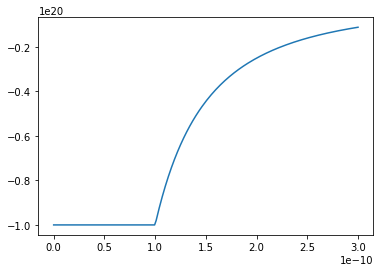

In [42]:
x = np.linspace(0,3*param["gamma"],200)
plt.plot(x,psix_vec(x,param["gamma"]))

# Functions and first order derivatives

In [43]:
#Base functions
Eeps = lambda x:param["epsilon"]/2*np.linalg.norm(x)**2
Edata = lambda x:f1(x,p[:-1],y,fourier_op)
Enonneg = lambda x:b(x,param["zeta"])
Ereg = lambda x:param["pn1"]*np.sum(rho_vec(linear_op.op(x),param["gamma"]))
Etot = lambda x:Eeps(x)+Edata(x)+Enonneg(x)+Ereg(x)

#First order derivatives
Du_Eeps = lambda x:param["epsilon"]*x
Du_Edata = lambda x:np.real(fourier_op.adj_op(p[:-1]**2*(fourier_op.op(Rstar(x))-y)))
Du_Enonneg = lambda x:-3*param["zeta"]*np.where(x<=0,x**2,0)
Du_Ereg = lambda x:param["pn1"]*linear_op.adj_op(phi_vec(linear_op.op(x),param["gamma"])*linear_op.op(x))
Du_Etot = lambda x:Du_Eeps(x)+Du_Edata(x)+Du_Enonneg(x)+Du_Ereg(x)

### Numerical check
Plots of $\left|\frac{f(a+th)-f(a)-<\nabla f(a),th>}{t}\right|$ for $t\rightarrow 0$. Eeps, Edata and Enonneg seem to work, but problem with Ereg.

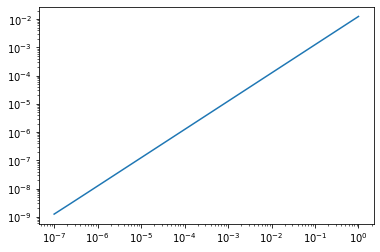

In [44]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

tests = np.logspace(-7,0,20)
real_values = np.array([Eeps(a+t*a2) for t in tests])
approx = np.array([Eeps(a)+t*np.sum(Du_Eeps(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

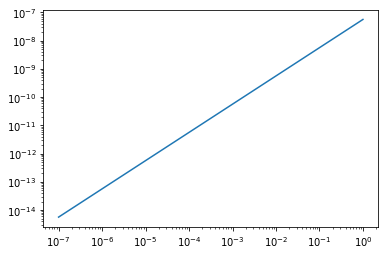

In [45]:
# -- Edata --
#Random vector with same amplitude as u0
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)

p=radial_p
tests = np.logspace(-7,0,20)
real_values = np.array([Edata(u0_mat+t*a2) for t in tests])
approx = np.array([Edata(u0_mat)+t*np.sum(Du_Edata(u0_mat)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

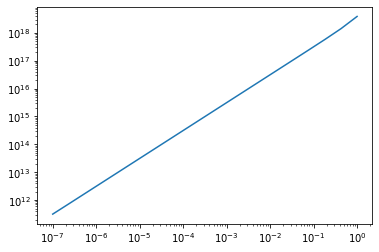

In [46]:
# -- Enonneg --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

tests = np.logspace(-7,0,20)
real_values = np.array([Enonneg(a+t*a2) for t in tests])
approx = np.array([Enonneg(a)+t*np.sum(Du_Enonneg(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

/home/guillaume/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


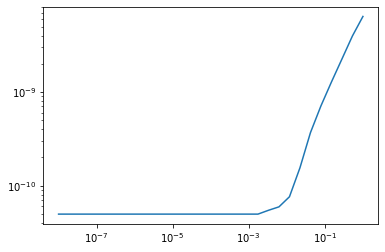

In [47]:
# -- Ereg --
#Random vector with same amplitude as u0
a = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)
#a=u0_mat
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-8,-0,30)
real_values = np.array([Ereg(a+t*a2) for t in tests])
approx = np.array([Ereg(a)+t*np.sum(Du_Ereg(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

In [48]:
print(Ereg(a))

1.5702441081455845e-08


Gap between limits:4.949782611068313e-19


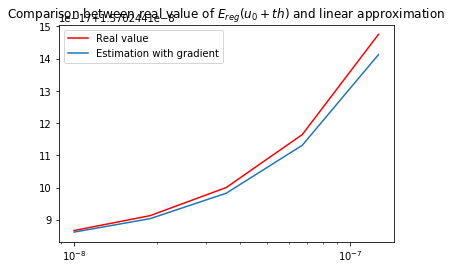

In [49]:
print(f"Gap between limits:{real_values[0]-approx[0]}")

plt.plot(tests[:5],real_values[:5],'r',label="Real value")
plt.plot(tests[:5],approx[:5],label="Estimation with gradient")
plt.xscale("log")
plt.title("Comparison between real value of $E_{reg}(u_0+th)$ and linear approximation")
plt.legend()

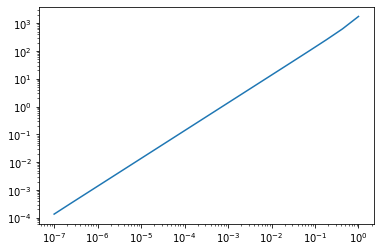

In [50]:
# -- Etot --
#Random vector with same amplitude as u0
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)
a = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)
#a=u0_mat

tests = np.logspace(-7,0,20)
real_values = np.array([Etot(a+t*a2) for t in tests])
approx = np.array([Etot(a)+t*np.sum(Du_Etot(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

# Second order derivatives
We don't express the hessians as matrices but as linear operators. Same verifications: $\frac{||\nabla f(a+th)-(\nabla f(a)+t\nabla^2f(a)h)||_2}{t}$.

In [51]:
def Du2_Eeps(u,p,w):return param["epsilon"]*w
def Du2_Edata(u,p,w):return np.real(fourier_op.adj_op(p[:-1]**2*fourier_op.op(w)))
def Du2_Enonneg(u,p,w):return -6*param["zeta"]*np.where(u<0,u,0)*w
def Du2_Ereg(u,p,w):
    lin_u = linear_op.op(u)
    lin_w = linear_op.op(w)
    psi_Au = psix_vec(lin_u,param["gamma"])
    phi_Au = phi_vec(lin_u,param["gamma"])
    return p[-1]*(linear_op.adj_op(lin_u**2*lin_w*psi_Au+phi_Au*lin_w))
def Du2_Etot(u,p,w):return Du2_Eeps(u,p,w)+Du2_Edata(u,p,w)+Du2_Enonneg(u,p,w)+Du2_Ereg(u,p,w)

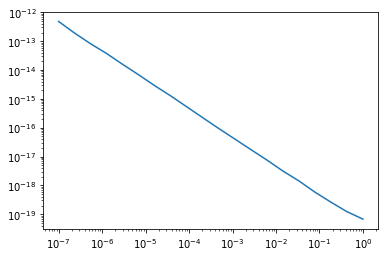

In [52]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
Dua = Du_Eeps(a)
real = []
approx = []
for t in tests:
    real.append(Du_Eeps(a+t*a2))
    approx.append(Dua+t*Du2_Eeps(a,p,a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

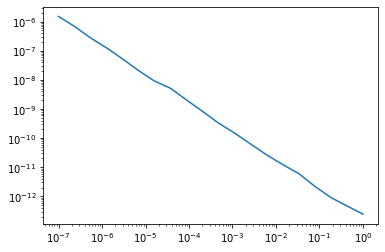

In [53]:
# -- Edata --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Edata(a+t*a2))
    approx.append(Du_Edata(a)+Du2_Edata(a,radial_p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

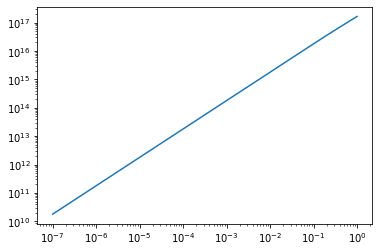

In [54]:
# -- Enonneg --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Enonneg(a+t*a2))
    approx.append(Du_Enonneg(a)+Du2_Enonneg(a,p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

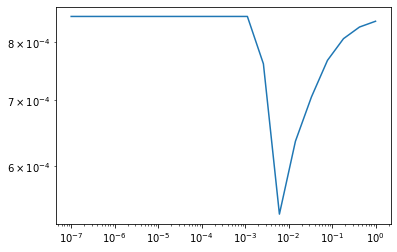

In [55]:
# -- Ereg --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Ereg(a+t*a2))
    approx.append(Du_Ereg(a)+Du2_Ereg(a,p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

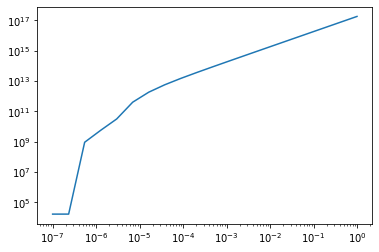

In [56]:
# -- Etot --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a=u0_mat
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Etot(a+t*a2))
    approx.append(Du_Etot(a)+Du2_Etot(a,p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

## Cross derivatives

In [57]:
def Dpu_Edata(u,p,w):
    Fu = np.conj(fourier_op.op(Rstar(u))-y)
    Fw = fourier_op.op(w)
    return 2*p[:-1]*np.real(Fu*Fw)
def Dpu_Ereg(u,p,w):
    return p[-1]*np.sum(w*linear_op.adj_op(phi_vec(linear_op.op(u),param["gamma"])*linear_op.op(u)))

def Dpu_Etot(u,p,w):
    g = np.zeros((n**2+1,))
    g[:-1] = Dpu_Edata(u,p,w)
    g[-1] = Dpu_Ereg(u,p,w)
    return g

## Loss function and penalty

In [158]:
c = 1e0
def L(u,u2):return c*np.linalg.norm(u-u2)**2
def grad_L(u,u2):return 2*c*(u-u2)

beta = 1e-10*c
def P(p):return beta*np.sum(p[:-1]*(2-p[:-1]))
def grad_P(p):
    Dp = 2*(1-p)
    #Don't change alpha
    Dp[-1] = 0
    return beta*Dp
# P = lambda x:beta*np.linalg.norm(p)**2
# grad_P = lambda x:2*beta*x

In [82]:
param["pn1"]=1e-6
p = np.copy(radial_p)
uk,norms,energy = pdhg(y,p[:-1],fourier_op,linear_op,param,maxit=20,verbose=0)
print(f"L(u(p))={L(uk,u0_mat)}\nP(p)={P(p)}")

Finished in 0.1527271270751953 seconds.
L(u(p))=1.1310234180081462e-09
P(p)=1.8789999999999998e-08


# Upper level energy

In [125]:
uk = np.zeros(u0_mat.shape)

def E(pk):
    global uk
    print("\nEvaluating E(p)")
    param["pn1"]=pk[-1]
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=20,verbose=0)
    return L(uk,u0_mat)+P(pk)

cgconv = []
def grad_E(pk,max_cgiter=3000,tol=1e-8,compute_conv=False):
    global uk,cgconv
    #Update alpha(p)
    param["pn1"]=pk[-1]
    
    print("\nStarting PDHG")
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=30,verbose=0)
    
    def mv(w):
        w = np.reshape(w,(n,n))
        return np.reshape(Du2_Etot(uk,pk,w),(n**2,))
    
    
    # -- Use cg to compute gradient --
    lin = LinearOperator((n**2,n**2),matvec=mv)
    B = np.reshape(grad_L(uk,u0_mat),(n**2,))
    def cgcall(x):
        if compute_conv:cgconv.append(np.linalg.norm(lin(x)-B)/np.linalg.norm(B))
    
    t1=time.time()
    print("\nStarting Conjugate Gradient method")
    x_inter,convergence = cg(lin,B,tol=tol,maxiter=max_cgiter,callback=cgcall)
    print(f"Finished in {time.time()-t1}s - ||Ax-b||/||b||: {np.linalg.norm(lin(x_inter)-B)/np.linalg.norm(B)}")
    return Dpu_Etot(uk,pk,np.reshape(x_inter,(n,n)))+grad_P(pk)

# Callback function
niter = 0
def fcall(x):
    global uk,niter
    niter += 1
    print("\033[1m" + f"\n{niter} iterations: ssim={ssim(uk,u0_mat)}\n\n" + "\033[0m")

In [88]:
p0 = np.random.rand(n**2+1)
Ep0,gradEp0 = E(p0),grad_E(p0)
p1 = np.random.rand(n**2+1)

tests = np.logspace(-9,0,30)
real_values = np.array([E(p0+t*p1) for t in tests])
approx = np.array([Ep0+t*np.sum(gradEp0*p1) for t in tests])


Evaluating E(p)
Finished in 0.11686229705810547 seconds.

Starting PDHG
Finished in 0.15758347511291504 seconds.

Starting Conjugate Gradient method
Relative error: 1.1271488536440373
Relative error: 0.9237142576483576
Relative error: 1.0656678621292524
Relative error: 1.4672764451275393
Finished in 0.5842146873474121s - ||Ax-b||/||b||: 1.4672764451275393

Evaluating E(p)
Finished in 0.09261345863342285 seconds.

Evaluating E(p)
Finished in 0.0921790599822998 seconds.

Evaluating E(p)
Finished in 0.1041100025177002 seconds.

Evaluating E(p)
Finished in 0.11605191230773926 seconds.

Evaluating E(p)
Finished in 0.09299540519714355 seconds.

Evaluating E(p)
Finished in 0.08931493759155273 seconds.

Evaluating E(p)
Finished in 0.10646724700927734 seconds.

Evaluating E(p)
Finished in 0.09018969535827637 seconds.

Evaluating E(p)
Finished in 0.09016704559326172 seconds.

Evaluating E(p)
Finished in 0.10241913795471191 seconds.

Evaluating E(p)
Finished in 0.08934903144836426 seconds.

Eval

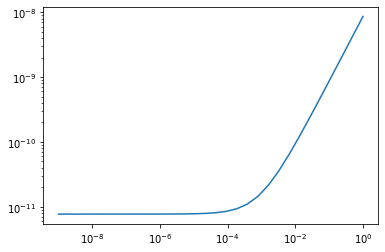

In [90]:
plt.plot(tests,abs((real_values-approx)/tests))
plt.xscale("log")
plt.yscale("log")

In [92]:
gP = grad_E(p,max_cgiter=3000,tol=1e-10,compute_conv=True)


Starting PDHG
Finished in 0.16615843772888184 seconds.

Starting Conjugate Gradient method
Relative error: 9.4638111403801
Relative error: 8.672552926758692
Relative error: 3.72120455670533
Relative error: 2.9599133266975084
Relative error: 3.7437341076952224
Relative error: 1.7979043350552055
Relative error: 1.9389360990961957
Relative error: 1.5651994527880853
Relative error: 2.062202397443076
Relative error: 1.761495281477733
Relative error: 0.829519125361597
Relative error: 0.5489123462477152
Relative error: 0.5595104884617477
Relative error: 0.7928629946976109
Relative error: 0.5067257820891794
Relative error: 0.36189526982593495
Relative error: 0.34132476817878005
Relative error: 0.2144693217762808
Relative error: 0.24851923669639614
Relative error: 0.25497611992950325
Relative error: 0.12642432189848965
Relative error: 0.16744374437178408
Relative error: 0.14716961423161568
Relative error: 0.08118108259745618
Relative error: 0.134848128695441
Relative error: 0.05374477209352503

Text(0, 0.5, '||Ax-b||/||b||')

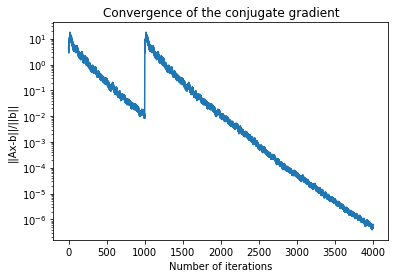

In [93]:
plt.plot(cgconv)
plt.yscale("log")
plt.title("Convergence of the conjugate gradient")
plt.xlabel("Number of iterations")
plt.ylabel("||Ax-b||/||b||")
#plt.savefig("Upper Level/CG_conv.png")

# L-BFGS-B

In [178]:
# p0 = 0.9*p+0.1*np.random.rand(n**2+1)
p0 = np.random.rand(n**2+1)
# p0=np.ones(n**2+1)
p0[-1] = 1e-6

In [179]:
niter = 0
x,Emin,info = fmin_l_bfgs_b(E,p0,grad_E,bounds=[(0,1)]*n**2+[(0,np.inf)],pgtol=1e-11,
                           maxfun=1000,maxiter=1000,
                            callback = fcall)


Evaluating E(p)
Finished in 0.10639452934265137 seconds.

Starting PDHG
Finished in 0.1592855453491211 seconds.

Starting Conjugate Gradient method
Finished in 14.700314044952393s - ||Ax-b||/||b||: 2.587987348291716

Evaluating E(p)
Finished in 0.09035229682922363 seconds.

Starting PDHG
Finished in 0.15856051445007324 seconds.

Starting Conjugate Gradient method
Finished in 14.698318481445312s - ||Ax-b||/||b||: 5.329076561619176

Evaluating E(p)
Finished in 0.08950352668762207 seconds.

Starting PDHG
Finished in 0.18056535720825195 seconds.

Starting Conjugate Gradient method


KeyboardInterrupt: 

In [176]:
pf = res.x
print(E(p0),E(pf))


Evaluating E(p)
Finished in 0.11043310165405273 seconds.

Evaluating E(p)
Finished in 0.14274215698242188 seconds.
1.6939558400073071e-07 2.5073300245877407e-07


In [177]:
print(pf[-1])
pysap.Image(data=np.reshape(pf[:-1],(n,n))).show()

1e-06


10  iterations:
Cost: 5.439026602966341e-09 
Norm: 0.05660764219612862 

20  iterations:
Cost: 5.407972516679958e-09 
Norm: 0.0032040722098140182 

30  iterations:
Cost: 5.404728919283458e-09 
Norm: 0.000783407474819563 

40  iterations:
Cost: 5.404112860901755e-09 
Norm: 0.0004767721406664516 

50  iterations:
Cost: 5.403884315288288e-09 
Norm: 0.00029591305762731424 

60  iterations:
Cost: 5.403825572224563e-09 
Norm: 0.00023286996158221196 

70  iterations:
Cost: 5.403800844474262e-09 
Norm: 0.00014362952059123938 

80  iterations:
Cost: 5.403789203350742e-09 
Norm: 9.665309261932059e-05 

Finished in 0.6531422138214111 seconds.
0.8858134658938746


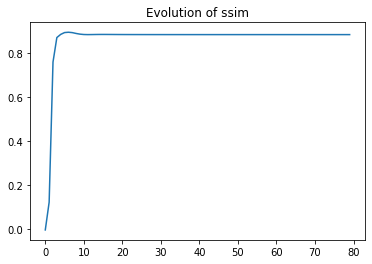

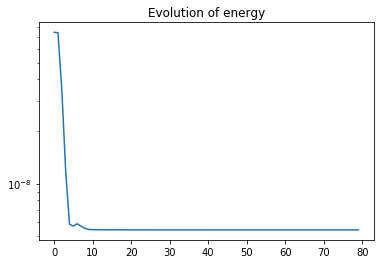

In [155]:
uk,norms,energy,ssims = pdhg(y,pf[:-1],fourier_op,linear_op,param,real_image=u0_mat,maxit=100)
print(ssim(uk,u0_mat))

plt.figure()
plt.plot(ssims)
plt.title("Evolution of ssim")
plt.show()

plt.figure()
plt.plot(energy)
plt.title("Evolution of energy")
plt.yscale("log")
plt.show()

pysap.Image(data=uk).show()